## Problem 1 :

### 1.Building the Model
__________
**1.1) Build an MLP  and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of [0.5M, 1.0M].**

The model is implemented within the NN class below.

Given that the input size is 784 and we have 10 classes, we estimaed the size of each hidden layer as follow:

- first hidden layer: 500 units
- second hidden layer: 400 units

and the total number of parameters in our model with these settings is: $(784+1)*500 + (500+1)*400 + (400+1)*10 = 596910$


**1.2) Implement the forward and backward propagation of the MLP in numpy without using any of the deep learning frameworks that provides automatic differentiation.**

We implemented the forward and backword propagation using the matrix form of the network. Hence, we tend to avoid using loops whenever it is possible.

Our algorithm implements minibatch gradient descent, which allows us to save a lot of computation thanks to matrix operations (we can use 1-example stochastic gradient descent by specifying batch_size = 1).

- forward :
Each batch is represented by a $\mbox{batch_size} \times 784$ matrix. It can be treated as the output $H_0$ of a $1^{st}$ layer with indexation starting from 0.

for each hidden layer i with $1\leq i \leq L$, we compute the input as $ A_{i} = H_{i-1}W_{i} + b_{i}$ with dimensions: 

- $W_{i}$   : $h^{i-1} \times h^{i}$ 
- $H_{i-1}$ : $  batch\_size \times h^{i-1}$
- $b_{i}$: $  1 \times h^{i}$

As we can see $H_{i-1}W_{i}$ and $b_{i}$ don't have the same first dimension, but thanks to the broadcast property provided by numpy it is not an issue.

Next, after using this linear transformation, we apply an activation function $ReLU$ on $A_{i}$ which gives us $H_{i} = ReLU(A_{i})$

the output layer it has 

and $h^i$ is the number of units of the i^{th} layer

## TODO

for more details see the class NN below.

**1.3) Train the MLP using the probability loss ($\textit{cross entropy}$) as training criterion. We minimize this criterion to optimize the model parameters using $\textit{stochastic gradient descent}$.**

bla blaa

In [160]:
# For live plot:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict1, title1, data_dict2, title2, figsize=(7,5), bestEpoch=0):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    for label,data in data_dict1.items():
        plt.plot(data, label=label)
        if label == 'validation accuracy':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title1)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.subplot(1,2,2)
    for label,data in data_dict2.items():
        plt.plot(data, label=label)
        if label == 'validation loss':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title2)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show();

# For NN operations:
import numpy as np
import pickle
import copy
import time

"""MLP class :

The model implemented as follows :
Each layers is represented by a b vector (biases) and a W matrix (weights)
These are referenced by the weights dictionary. The format is :
self.weights[f"X{n}"] where X = b, W
NB : In our implementation, all matrices are transposed compared to the class notations
"""
class NN(object):
    
    def __init__(self,
                 hidden_dims=(1024, 2048),   # dimensions of each hidden layers
                 n_hidden=2,                 # number of hidden layers
                 mode='train',               # current mode : train/test
                 datapath=None,              # path where to find the .pkl file
                 model_path=None,            # path where to save/load the model 
                 epsilon = 1e-6,             # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                 lr = 1e-1,                  # learning rate
                 n_epochs = 1000,            # max number of epochs
                 batch_size = 1000,          # batch size for training
                 compute_biases = True,      # whether biases are used or not
                 seed = None,                  # seed for reproducibility 
                 activation = "relu",        # activation function
                 init_method="glorot"):      # initialization method
        """
        - method: (string) - initializes the weight matrices
            -> "zero" for a Zero initialisation of the weights
            -> "normal" for a Normal initialisation of the weights
            -> "glorot" for a Uniform initialisation of the weights
        """
        assert len(hidden_dims) == n_hidden, "Hidden dims mismatch!"
        
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.mode = mode
        self.datapath = datapath
        self.model_path = model_path
        self.epsilon = epsilon
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.compute_biases = compute_biases
        self.init_method = init_method
        self.seed = seed
        self.activation_str = activation
        
        self.dataplot1 = collections.defaultdict(list)
        self.dataplot2 = collections.defaultdict(list)
        
        self.bestValLoss = np.Infinity # min value of the validation loss
        self.bestEpoch = 0 # epoch where we reached the min value of the validation loss
        self.bestWeights = None # optimal weights dictionary (contains biases when compute_biases=True)
        
        # train, validation and test sets :
        self.tr, self.va, self.te = np.load(open(datapath, "rb"))

    def initialize_weights(self, dims):
        """
        Initializes the weights and biases according to the specified method :
        - dims: (list of two integers) - the size of input/output layers
        :return: None
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        if self.mode == "train":
            self.weights = {}
            all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
            #print("Layers dimensions are : ", all_dims)
            for layer_n in range(1, self.n_hidden + 2):
                if self.init_method == "zero":
                    self.weights[f"W{layer_n}"] = np.zeros(shape=(all_dims[layer_n - 1],all_dims[layer_n])).astype('float64')
                elif self.init_method == "normal":
                    #Be aware of the error you get "true divide", can be solved by dividing by dim_layer[n-1] 
                    self.weights[f"W{layer_n}"] = np.random.normal(loc=0.0, scale=1.0, size=(all_dims[layer_n - 1],
                                                                                             all_dims[layer_n])).astype('float64')/all_dims[layer_n-1]
                elif self.init_method == "glorot":
                    b = np.sqrt(6.0/(all_dims[layer_n]+all_dims[layer_n-1]))
                    self.weights[f"W{layer_n}"] = np.random.uniform(low=-b, high=b, size=(all_dims[layer_n - 1],
                                                                                            all_dims[layer_n])).astype('float64')
                else:
                    raise Exception("The provided name for the initialization method is invalid.")
                
                if self.compute_biases:
                    self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
                    
        elif self.mode == "test":
            self.weights = np.load(self.model_path)
        else:
            raise Exception("Unknown Mode!")
    
    def relu(self,x, prime=False):# Prime for Step function, else ReLu
        if prime:
            return x > 0
        return np.maximum(0, x)
    
    def sigmoid(self,x, prime=False):
        if prime:
            return self.sigmoid(x)*(1 -  self.sigmoid(x))
        return 1/(1 + np.exp(-x))
    
    def tanh(self,x, prime=False):
        if prime:
            return 1 -  np.power(self.tanh(x),2)
        return np.tanh(x)
    
    def activation(self, input_, prime=False):  
        if self.activation_str == "relu":
            return self.relu(input_,prime)
        elif self.activation_str == "sigmoid":
            return self.sigmoid(input_,prime)
        elif self.activation_str == "tanh":
            return self.tanh(input_,prime)
        else:
            raise Exception("Unsupported activation!")

    def softmax(self, input_):  # Computes the softmax of the input
        """
        Documentation
        """
        Z = np.exp(input_ - np.max(input_)) # softmax(x-C) = softmax(x) (stability)
        return Z / np.sum(Z, axis=1, keepdims=True)
    
    def forward(self, input_):  # Forward propagation : computes the outputs (cache) from the input
        """
        Documentation
        """
        cache = {"H0": input_}
        for layer in range(1, self.n_hidden + 1):
            if self.compute_biases:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
            else:
                cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
            cache[f"H{layer}"] = self.activation(cache[f"A{layer}"])

        layer = self.n_hidden + 1
        if self.compute_biases:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"] + self.weights[f"b{layer}"]
        else:
            cache[f"A{layer}"] = cache[f"H{layer-1}"] @ self.weights[f"W{layer}"]
        cache[f"H{layer}"] = self.softmax(cache[f"A{layer}"]) # softmax on last layer
        return cache
    
    def backward(self, cache, labels):  # Backward propagation : computes the gradients from the outputs (cache)
        """
        Documentation
        """
        output = cache[f"H{self.n_hidden+1}"]
        grads = {f"dA{self.n_hidden+1}": - (labels - output)}
        for layer in range(self.n_hidden + 1, 0, -1):
            # the following operation averages at once all the matrices
            # that we would have calculated for each example of the minibatch if we had not represented it in matrix form :
            grads[f"dW{layer}"] = cache[f"H{layer-1}"].T @ grads[f"dA{layer}"] / self.batch_size
            # we need to do the same for the biases gradients :
            if self.compute_biases:
                grads[f"db{layer}"] = np.mean(grads[f"dA{layer}"], axis=0, keepdims=True)
            if layer > 1:
                grads[f"dH{layer-1}"] = grads[f"dA{layer}"] @ self.weights[f"W{layer}"].T
                grads[f"dA{layer-1}"] = grads[f"dH{layer-1}"] * self.activation(cache[f"A{layer-1}"], prime=True)
        return grads
    
    def update(self, grads):  # To update the weights and the biases
        """
        Documentation
        """
        for layer in range(1, self.n_hidden + 1):
            self.weights[f"W{layer}"] = self.weights[f"W{layer}"] - self.lr * grads[f"dW{layer}"]
            if self.compute_biases:
                self.weights[f"b{layer}"] = self.weights[f"b{layer}"] - self.lr * grads[f"db{layer}"]
    
    def loss(self, prediction, labels):  # Computes the cross entropy
        """
        Documentation
        """
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        return -1 * np.sum(labels * np.log(prediction)) / prediction.shape[0]
    
    def computeLossAndAccuracy(self, X, y):  # Stores the accuracy/loss of the train/validation sets
        """
        Documentation
        """
        on_y = self._one_hot(y)
        vCache = self.forward(X)
        vOut = np.argmax(vCache[f"H{self.n_hidden + 1}"], axis=1)
        vAccuracy = np.mean(y == vOut)
        vLoss = self.loss(vCache[f"H{self.n_hidden+1}"], on_y)
        return vLoss, vAccuracy, vOut
    
    def _one_hot(self,y):
        """
        """
        _, y_train = self.tr
        return np.eye(np.max(y_train) - np.min(y_train) + 1)[y]
    
    def train(self,show_graph = True, save_model = True):
        """
        Documentation
        """
        X_train, y_train = self.tr
        y_onehot = self._one_hot(y_train)
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(self.n_epochs):
            predictedY = np.zeros_like(y_train)
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                cache = self.forward(minibatchX)
                grads = self.backward(cache, minibatchY)
                self.update(grads)
                predictedY[self.batch_size * batch:self.batch_size * (batch + 1)] = np.argmax(
                    cache[f"H{self.n_hidden + 1}"], axis=1)
                
            X_tr, y_tr = self.tr
            trLoss, trAccuracy,_ = self.computeLossAndAccuracy(X_tr, y_tr)
            X_val, y_val = self.va
            valLoss, valAccuracy,_ = self.computeLossAndAccuracy(X_val, y_val)
            
            if valLoss < self.bestValLoss:
                self.bestValLoss = valLoss
                self.bestEpoch = epoch
                self.bestWeights = copy.deepcopy(self.weights)
            
            self.dataplot1['train accuracy'].append(trAccuracy)
            self.dataplot1['validation accuracy'].append(valAccuracy)
            self.dataplot2['train loss'].append(trLoss)
            self.dataplot2['validation loss'].append(valLoss)
            if show_graph:
                live_plot(self.dataplot1, "Accuracy", self.dataplot2, "Loss", (14,5), self.bestEpoch)
        
        if save_model:
            # Save Best Model
            if self.model_path is None:
                string_hdims = "-".join(map(str,self.hidden_dims))
                model_name = f"best-model-init-{self.init_method}-lr-{self.lr}-hdims-{string_hdims}-batchs-{self.batch_size}.npz"
                np.savez(model_name,**self.bestWeights)
            else:
                np.savez(self.model_path,**self.bestWeights)
            
        return self.dataplot1, self.dataplot2
    
    def test(self):
        X_te, y_te = self.te
        vLoss, vAccuracy,_ = self.computeLossAndAccuracy(X_te, y_te)
        print(f"Test Accuracy:{vAccuracy}, Test Loss:{vLoss}")

### 2. Initialization

**2.1) Train the model for 10 epochs using the initialization methods and record the average loss measured on the training data at the end of each epoch (10 values for each setup).**

**- Initialization with zeros:**

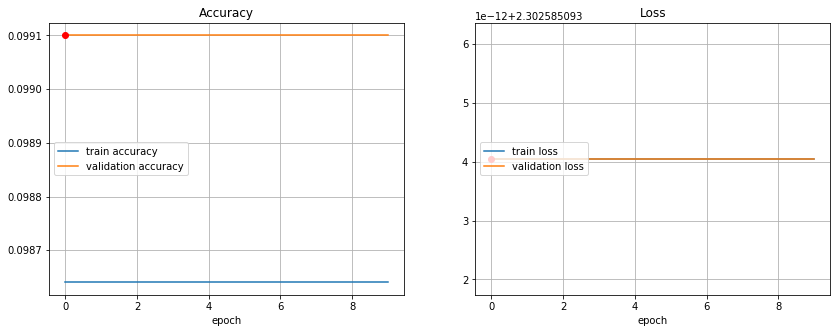

In [61]:
#Zero_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.npy",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,           # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "zero")        # initialization method
_, _= neural_net.train()

**- Initialization with a Standard Normal distribution:**

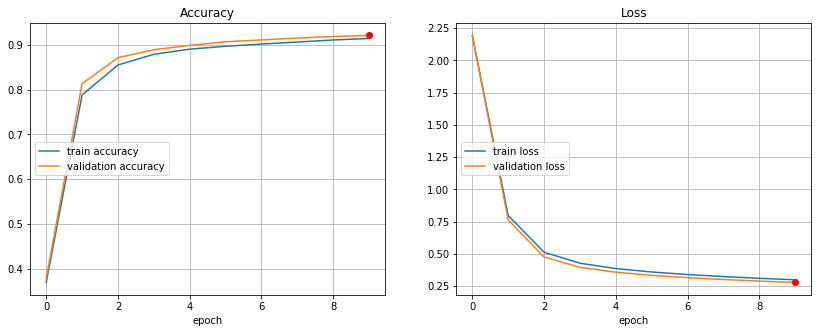

In [57]:
#Normal init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.npy",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,            # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "normal")      # initialization method
normal_hist_acc, normal_hist_loss = neural_net.train()

**- Initialization with Glorot method:**

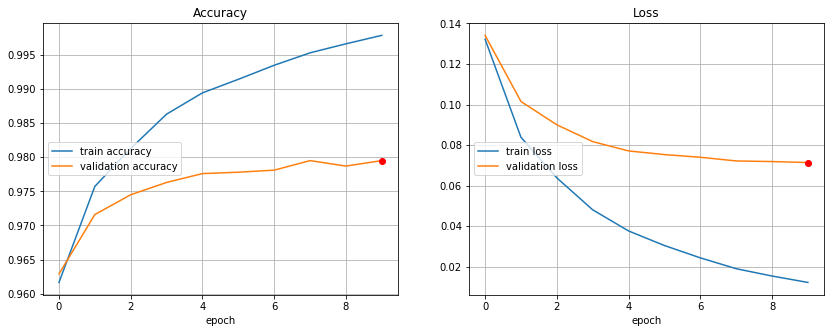

In [76]:
#Glorot_Init
neural_net = NN(hidden_dims=(500, 400),
                n_hidden=2,                  # number of hidden layers
                mode='train',                # current mode : train/test
                datapath="mnist.npy",        # path where to find the .pkl file
                model_path=None,             # path where to save/load the model 
                epsilon = 1e-8,              # for cross entropy calculus stability : log(x) = log(epsilon) if x < epsilon
                lr = 5e-1,                   # learning rate
                n_epochs = 10,               # max number of epochs
                batch_size = 100,            # batch size for training
                compute_biases = True,       # whether biases are used or not
                init_method = "glorot")      # initialization method
glorot_hist_acc, glorot_hist_loss = neural_net.train()

**2.1) Compare the three setups by plotting the losses against the training time (epoch) and comment on the result.**

### 3. Hyperparameter Search

**3.1) Find out a combination of hyper-parameters (model architecture, learning rate, nonlinearity, etc.) such that the average accuracy rate on the validation set ($r^{(valid)}$) is at least 97\%.**

In [216]:
class RandomSearch:
    
    def __init__(self,model,params,n_itters,seed = 42):
        self.params = params
        self.n_itters = n_itters
        self.model = model
        self.seed = seed
        
    def run(self):

        #np.random.seed(self.seed)
        results = []
        best_acc = None
        best_loss = None
        params = [p for p in self._generate_grid()]
        for it,selected_params in enumerate(params):
            try:
                instance_model = self.model(seed = self.seed,**selected_params)
                acc, loss = instance_model.train(show_graph=False,save_model=False)
                id_best = np.argmin(loss)

                results.append((selected_params, loss["validation loss"][id_best], acc["validation accuracy"][id_best]))

                if best_acc is None or best_loss> loss["validation loss"][id_best]:
                    print(f"Found a better model: Accuracy from {best_acc} to {acc['validation accuracy'][id_best]}")
                    best_loss = loss["validation loss"][id_best]
                    best_acc  = acc["validation accuracy"][id_best]
                print(f'Model {it+1}, accuracy {acc["validation accuracy"][id_best]:.5f}, loss {loss["validation loss"][id_best]:.5f}, Best Model: acc {best_acc:.5f}, loss {best_loss:.5f}')
            except KeyboardInterrupt:
                break
        return results
    
    def _generate_grid(self):
        for it in range(self.n_itters):
            yield self._select_params()
    def _select_params(self):
        selected_params = {}
        for key,value in self.params.items():
            if key == "hidden_dims":
                continue
            elif key == "n_hidden":
                assert type(value) == int and value>0
                hidden_units = []
                for _ in range(value):
                    hidden_units.append(np.random.choice(self.params["hidden_dims"]))
                selected_params["hidden_dims"] = hidden_units
                selected_params[key]=value
            elif type(value)==list or type(value)==tuple:
                selected_params[key] = np.random.choice(self.params[key])
            else:
                selected_params[key]=value
        return selected_params
    

In [217]:
grid_params = {
    "hidden_dims":[400,500,600,700],
    "n_hidden":2,
    "lr":[.05,.1,.5,1],
    "n_epochs":[10,20,25,30],
    "batch_size":[50,100,1000,5000],
    "activation":["tanh","sigmoid","relu"],
    "datapath":"mnist.npy",
}

rd_search = RandomSearch(
    model = NN,
    params = grid_params,
    n_itters = 100
)
experiments = rd_search.run()

Found a better model: Accuracy from None to 0.1266
Model 1, accuracy 0.12660, loss 2.27135, Best Model: acc 0.12660, loss 2.27135
Found a better model: Accuracy from 0.1266 to 0.9532
Model 2, accuracy 0.95320, loss 0.16412, Best Model: acc 0.95320, loss 0.16412
Model 3, accuracy 0.17520, loss 2.26653, Best Model: acc 0.95320, loss 0.16412
Model 4, accuracy 0.82920, loss 0.58257, Best Model: acc 0.95320, loss 0.16412
Model 5, accuracy 0.67660, loss 1.80809, Best Model: acc 0.95320, loss 0.16412
Model 6, accuracy 0.90950, loss 0.32197, Best Model: acc 0.95320, loss 0.16412
Found a better model: Accuracy from 0.9532 to 0.9584
Model 7, accuracy 0.95840, loss 0.14900, Best Model: acc 0.95840, loss 0.14900
Model 8, accuracy 0.89210, loss 0.44201, Best Model: acc 0.95840, loss 0.14900
Model 9, accuracy 0.87740, loss 0.51683, Best Model: acc 0.95840, loss 0.14900
Model 10, accuracy 0.92860, loss 0.25208, Best Model: acc 0.95840, loss 0.14900
Model 11, accuracy 0.90750, loss 0.34099, Best Model